In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [187]:
df = pd.read_csv('dataset.csv')
df = df.sample(frac=1.0, random_state=42)
df.head()

,Word,Language
15822,hagrid”,English
10093,envelopes,English
41442,praktikus,Danish
27496,utkast»,Norwegian
15943,fawkes,English


# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [188]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y = df.iloc[:, -1:]
y = pd.get_dummies(y).values
print(f"Amount of languages to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Rows: 73448
Amount of languages to identify: 7


In [202]:
model = Sequential()
model.add(Conv1D(128, 5, activation='relu'))  # Convolutional layer
model.add(GlobalMaxPooling1D())  # Pooling layer
model.add(Dense(64, activation='relu'))  # Dense layer
model.add(Dense(32, activation='relu'))  # Dense layer
model.add(Dense(len(y[1]), activation='softmax'))  # Output layer, num_classes is the number of languages
adam = optimizers.Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', 'categorical_crossentropy'])

In [203]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=256, batch_size=1000,verbose=1)

Epoch 1/256
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2246 - categorical_crossentropy: 1.9656 - loss: 1.9656 - val_accuracy: 0.3094 - val_categorical_crossentropy: 1.7830 - val_loss: 1.7830
Epoch 2/256
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2972 - categorical_crossentropy: 1.7851 - loss: 1.7851 - val_accuracy: 0.2914 - val_categorical_crossentropy: 1.7695 - val_loss: 1.7695
Epoch 3/256
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3190 - categorical_crossentropy: 1.7481 - loss: 1.7481 - val_accuracy: 0.3507 - val_categorical_crossentropy: 1.7092 - val_loss: 1.7092
Epoch 4/256
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3476 - categorical_crossentropy: 1.7003 - loss: 1.7003 - val_accuracy: 0.3610 - val_categorical_crossentropy: 1.6620 - val_loss: 1.6620
Epoch 5/256
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3656 - categorical_crossentropy: 1.6639 - loss: 1.6639 - val_accuracy: 0.3724 - val_categorical_crossentropy: 1.6318 - val_los

Text(0.5, 0, 'Epoch')

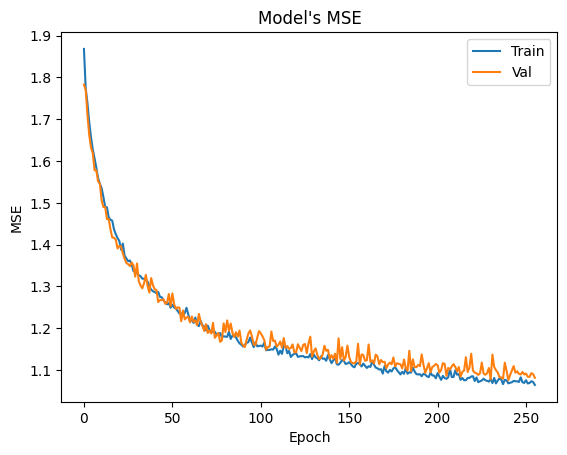

In [204]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's MSE")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('MSE')
plt.xlabel('Epoch')

# Prediction

In [205]:
prediction_word = "español"
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)

result = []
class_labels = df.iloc[:, -1].unique()
for index, prediction in enumerate(output_probabilities[0]):
    result.append(f"{class_labels[index]} - {round(prediction*100, 1)}%")

for r in result:
    print(r)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
English - 49.0%
Danish - 0.1%
Norwegian - 0.6%
Italian - 44.0%
Spanish - 5.8%
French - 0.0%
Swedish - 0.6%
